# Machine Learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# configure matplotlib output
import matplotlib as mpl
mpl.style.use('config/clean.mplstyle') # this loads my personal plotting settings
%matplotlib inline

In [3]:
# if you have an HD display
%config InlineBackend.figure_format = 'retina'

In [4]:
# warnings are again annoying
import warnings
warnings.filterwarnings('ignore')

In [5]:
import tensorflow as tf

In [6]:
batch_size = 1000 # how we feed it into the trainer

In [7]:
def batch_dict(dat, bs):
    nd = [dat[k].shape[0] for k in dat]
    nmin, nmax = min(nd), max(nd)
    assert(nmin == nmax)
    i = 0
    while i < nmax:
        yield {k: v[i:i+bs,...] for k, v in dat.items()}
        i += bs

## Regression

$$\log(\mathcal{L}) = -\frac{N}{2}\log(2\pi)-N\log(\sigma)-\sum_i \frac{1}{2}\left(\frac{y_i-\beta x_i}{\sigma}\right)^2$$

In [72]:
# generate random fake data
N = 1000
dat_x = np.random.randn(N)
dat_y = 3 + 2*dat_x + 0.5*np.random.randn(N)

In [73]:
# these are symbols representing our regression coefficients
beta0 = tf.Variable(2.0, dtype=tf.float64, name='beta0')
beta1 = tf.Variable(1.0, dtype=tf.float64, name='beta1')

In [74]:
# our prediction function
def predict(x):
    return beta0 + beta1*x

# out loss function
def log_like(y, yh):
    return tf.reduce_mean((y-yh)**2)

# our optimizer
optim = tf.optimizers.SGD(learning_rate=0.01)

In [75]:
# save history of training (the old fashioned way)
history = []

# list of params
params = [beta0, beta1]

# run for a fixed period and hope for convergence
for i in range(500):
    with tf.GradientTape() as g:
        pred = predict(dat_x)
        loss = log_like(dat_y, pred)

    gradients = g.gradient(loss, params)
    optim.apply_gradients(zip(gradients, params))

    history.append([p.numpy() for p in params])

# print out results
print(f'beta0 = {beta0.numpy()}')
print(f'beta1 = {beta1.numpy()}')

# turn history into dataframe
history = pd.DataFrame(history, columns=['beta0', 'beta1']).rename_axis('Iteration')

beta0 = 3.0066860065248995
beta1 = 2.0053976555261994


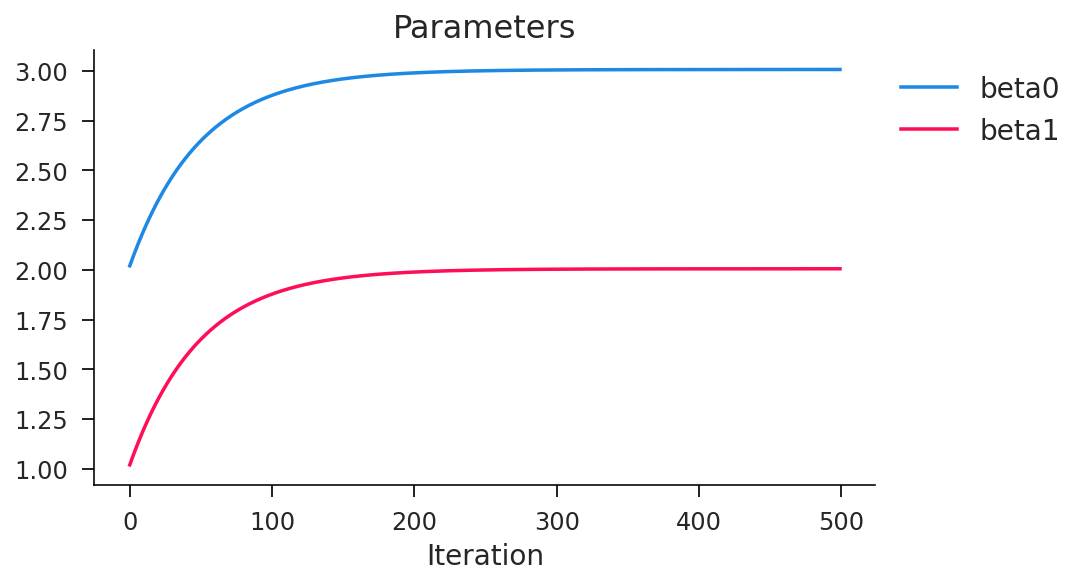

In [76]:
history.plot(title='Parameters', figsize=(7, 4));
plt.legend(bbox_to_anchor=(1.0, 1.0));

## Classification

In [9]:
dim = 100 # number of x dimensions (number of series)

In [10]:
# construct model symbolically as a graph (of placeholders, variables, and operations)
logit_graph = tf.Graph()
with logit_graph.as_default():
    # these are where we'll "feed" batches of data in
    x = tf.placeholder(dtype=tf.float64, shape=(None, dim), name='x')
    y = tf.placeholder(dtype=tf.float64, shape=(None,), name='y')

    # these are symbols representing our regression coefficients
    beta0 = tf.Variable(-10.0, dtype=tf.float64, name='beta0')
    beta1 = tf.Variable(0.5*np.ones(dim), dtype=tf.float64, name='beta1')

    # without cheating (divided by N)
    logits = beta0 + tf.squeeze(tf.matmul(x, tf.expand_dims(beta1, 1)))
    lell = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y)
    like = tf.reduce_mean(lell)
    
    # sigmoid_cross_entropy avoids overflow and is almost equivalent to:
    # prob = 1/(1+tf.exp(-logits))
    # lell = -(y*tf.log(prob)+(1-y)*tf.log(1-prob))
    
    # coefficient distribution
    b1avg = tf.reduce_mean(beta1)
    b1std = tf.sqrt(tf.reduce_mean(beta1**2)-b1avg**2)

    # prediction
    probab = tf.sigmoid(logits)
    predict = tf.cast(logits >= 0.0, dtype=tf.float64) # point prediction in {0,1}
    predavg = tf.reduce_mean(predict)

    # fit assessment
    bool_mean = lambda z: tf.reduce_mean(tf.cast(z, dtype=tf.float64))
    accuracy = bool_mean(tf.equal(predict, y))
    false_pos = bool_mean(tf.equal(predict, 1)&tf.equal(y, 0))
    false_neg = bool_mean(tf.equal(predict, 0)&tf.equal(y, 1))

    # this is an operation that optimizes an objective function
    opt = tf.train.AdamOptimizer(learning_rate=0.1)
    minn = opt.minimize(like)
    
    # this must go at the end!
    init = tf.global_variables_initializer()

In [12]:
def logistic_regression(x_data, y_data, K=100):
    sess = tf.get_default_session()
    
    # save history of training (the old fashioned way)
    history = []
    params = [beta0, b1avg, b1std, accuracy, false_pos, false_neg]
    names = ['beta0', 'b1avg', 'b1std', 'accuracy', 'false_pos', 'false_neg']

    # map real data into placeholders
    data = {x: x_data, y: y_data}

    # initialize variables (our coefficients)
    init.run()

    # run for a fixed period and hope for convergence
    for i in range(K):
        for batch in batch_dict(data, batch_size):
            minn.run(feed_dict=batch)
        history.append(sess.run(params, feed_dict=data))

    # turn history into dataframe
    history = pd.DataFrame(history, columns=names)
    
    # return results
    return history

### Linear Data

In [13]:
# simple hyperplane model
true_beta0 = 0.0
true_beta1 = 1.0*np.ones(dim)

In [14]:
N = 10000
space = np.random.randn(N, dim)
categ = (true_beta0 + np.dot(space, true_beta1) + np.random.logistic(size=N) > 0).astype(np.float64)
print(np.mean(categ))

0.4973


In [15]:
sess = tf.Session(graph=logit_graph)
with sess.as_default():
    history = logistic_regression(space, categ, K=100)
    est_beta0 = beta0.eval()
    est_beta1 = beta1.eval()
print(f'beta0 = {est_beta0}')
print(f'b1avg = {np.mean(est_beta1)}')
print(f'b1std = {np.std(est_beta1)}')

beta0 = 0.02858873389758191
b1avg = 0.9974303862270807
b1std = 0.054859431035599


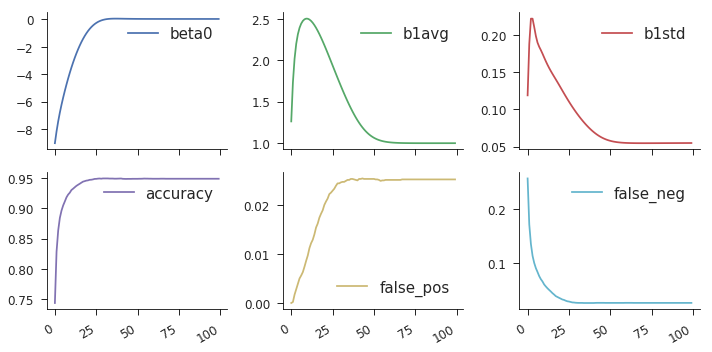

In [16]:
history.plot(subplots=True, layout=(2, 3), figsize=(10, 5));

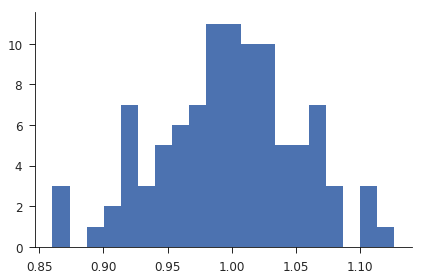

In [17]:
plt.hist(est_beta1, bins=20);

In [18]:
# look at out of sample properties (validation accuracy)
val_space = np.random.randn(N, dim)
val_categ = (true_beta0 + np.dot(val_space, true_beta1) + np.random.logistic(size=N) > 0).astype(np.float64)
val_data = {x: val_space, y: val_categ}
with sess.as_default():
    print('validation')
    print(f'predavg = {predavg.eval(feed_dict=val_data)}')
    print(f'accuracy  = {accuracy.eval(feed_dict=val_data)}')
    print(f'false_pos = {false_pos.eval(feed_dict=val_data)}')
    print(f'false_neg = {false_neg.eval(feed_dict=val_data)}')

validation
predavg = 0.4946
accuracy  = 0.9419
false_pos = 0.0295
false_neg = 0.0286


### Non-linear data

In [19]:
N = 1000
space = np.random.randn(N, dim)
categ = (np.sqrt(np.sum((space)**2, axis=1)) < np.sqrt(dim)).astype(np.float64)
print(np.mean(categ))

0.513


In [20]:
sess = tf.Session(graph=logit_graph)
with sess.as_default():
    history = logistic_regression(space, categ, K=300)
    est_beta0 = beta0.eval()
    est_beta1 = beta1.eval()
print(f'beta0 = {est_beta0}')
print(f'b1avg = {np.mean(est_beta1)}')
print(f'b1std = {np.std(est_beta1)}')

beta0 = 0.08736793357832615
b1avg = 0.020520120756741173
b1std = 0.0727949874173758


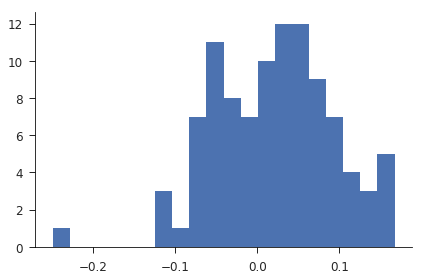

In [21]:
plt.hist(est_beta1, bins=20);

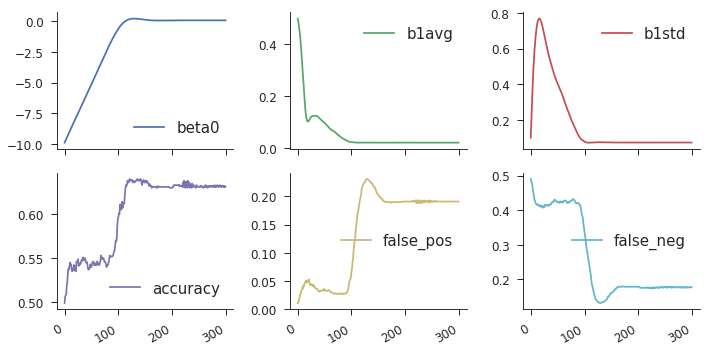

In [22]:
history.plot(subplots=True, layout=(2, 3), figsize=(10, 5));

In [23]:
# look at out of sample properties (validation accuracy)
val_space = np.random.randn(N, dim)
val_categ = (np.sqrt(np.sum(val_space**2, axis=1)) < np.sqrt(dim)).astype(np.float64)
val_data = {x: val_space, y: val_categ}
with sess.as_default():
    print('validation')
    print(f'predavg = {predavg.eval(feed_dict=val_data)}')
    print(f'accuracy  = {accuracy.eval(feed_dict=val_data)}')
    print(f'false_pos = {false_pos.eval(feed_dict=val_data)}')
    print(f'false_neg = {false_neg.eval(feed_dict=val_data)}')

validation
predavg = 0.574
accuracy  = 0.483
false_pos = 0.292
false_neg = 0.225


### Neural Networks

In [15]:
N = 10000
hill_func = lambda dat: (dat[:, 1] >= 2.5*dat[:, 0]*(1-dat[:, 0])).astype(np.float64)
# hill_func = lambda dat: (dat[:, 1] + 0.2*np.random.randn(dat.shape[0]) >= 2.5*dat[:, 0]*(1-dat[:, 0])).astype(np.float64)

train_space = np.random.rand(N, 2)
train_categ = hill_func(train_space)

valid_space = np.random.rand(1000, 2)
valid_categ = hill_func(valid_space)

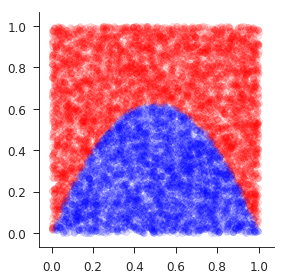

In [16]:
red_space = train_space[train_categ==1, :]
blue_space = train_space[train_categ==0, :]
fig, ax = plt.subplots()
ax.scatter(red_space[:, 0], red_space[:, 1], alpha=0.1, color='red');
ax.scatter(blue_space[:, 0], blue_space[:, 1], alpha=0.1, color='blue');
plt.axis('square');

In [24]:
# number of hidden units
hid = 2

# construct model symbolically as a graph (of placeholders, variables, and operations)
neural_graph = tf.Graph()
with neural_graph.as_default():
    # these are where we'll "feed" batches of data in
    x = tf.placeholder(dtype=tf.float64, shape=(None, 2), name='x')
    y = tf.placeholder(dtype=tf.float64, shape=(None,), name='y')

    # these are symbols representing our network weights
    W0 = tf.Variable(tf.random_normal((2, hid), dtype=tf.float64), name='weight0')
    b0 = tf.Variable(tf.random_normal((1, hid), dtype=tf.float64), name='bias0')

    W1 = tf.Variable(tf.random_normal((hid, 1), dtype=tf.float64), name='weight1')
    b1 = tf.Variable(tf.random_normal((1, 1), dtype=tf.float64), name='bias1')

    # two layer neural network, RELU + logits
    hidden = tf.nn.sigmoid(tf.matmul(x, W0) + b0)
    logits = tf.squeeze(tf.matmul(hidden, W1) + b1)
    
    # without cheating (divided by N)
    lell = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y)
    like = tf.reduce_mean(lell)

    # prediction
    probab = tf.sigmoid(logits)
    predict = tf.cast(logits >= 0.0, dtype=tf.float64) # point prediction in {0,1}
    predavg = tf.reduce_mean(predict)

    # fit assessment
    bool_mean = lambda z: tf.reduce_mean(tf.cast(z, dtype=tf.float64))
    accuracy = bool_mean(tf.equal(predict, y))
    false_pos = bool_mean(tf.equal(predict, 1)&tf.equal(y, 0))
    false_neg = bool_mean(tf.equal(predict, 0)&tf.equal(y, 1))

    # this is an operation that optimizes an objective function
    opt = tf.train.AdamOptimizer(learning_rate=0.1)
    minn = opt.minimize(like)
    
    # this must go at the end!
    init = tf.global_variables_initializer()

In [25]:
def neural_regression(train_x, train_y, valid_x, valid_y, K=100):
    sess = tf.get_default_session()
    
    # save history of training (the old fashioned way)
    train_hist = []
    valid_hist = []
    params = [accuracy, false_pos, false_neg]
    names = ['accuracy', 'false_pos', 'false_neg']

    # map real data into placeholders
    train_data = {x: train_x, y: train_y}
    valid_data = {x: valid_x, y: valid_y}

    # initialize variables (our coefficients)
    init.run()

    # run for a fixed period and hope for convergence
    for i in range(K):
        for batch in batch_dict(train_data, batch_size):
            minn.run(feed_dict=batch)
            pass
        train_hist.append(sess.run(params, feed_dict=train_data))
        valid_hist.append(sess.run(params, feed_dict=valid_data))

    # turn history into dataframe
    history = pd.concat([
        pd.DataFrame(train_hist, columns=names).add_prefix('train_'),
        pd.DataFrame(valid_hist, columns=names).add_prefix('valid_')
    ], axis=1)
    
    # return results
    return history

In [26]:
sess = tf.Session(graph=neural_graph)
with sess.as_default():
    history = neural_regression(train_space, train_categ, valid_space, valid_categ, K=200)
history.iloc[-1]

train_accuracy     0.9967
train_false_pos    0.0026
train_false_neg    0.0007
valid_accuracy     0.9980
valid_false_pos    0.0020
valid_false_neg    0.0000
Name: 199, dtype: float64

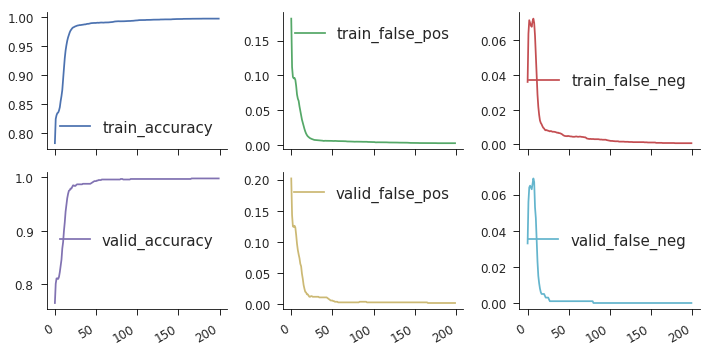

In [27]:
history.plot(subplots=True, layout=(2, 3), figsize=(10, 5));

In [28]:
# construct uniform grid over (x, y)
N = 100
test_grid = np.mgrid[0:1:N*1j,0:1:N*1j].reshape((2, -1)).T

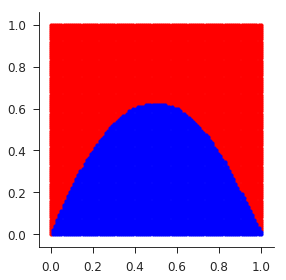

In [29]:
with sess.as_default():
    test_pred = predict.eval(feed_dict={x: test_grid}).astype(np.bool)
    
test_red = test_grid[test_pred, :]
test_blue = test_grid[~test_pred, :]

fig, ax = plt.subplots()
ax.scatter(test_red[:, 0], test_red[:, 1], color='red', s=10);
ax.scatter(test_blue[:, 0], test_blue[:, 1], color='blue', s=10);
plt.axis('square');

[-12.59193518  30.52602982  -9.3334931   31.21272153  17.76024767]
-0.2878070949651948


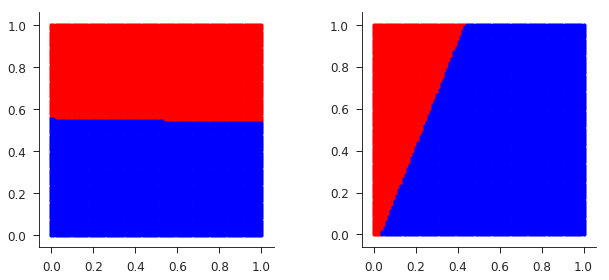

In [30]:
with sess.as_default():
    test_hidden = (hidden.eval(feed_dict={x: test_grid})>=0.5).astype(np.bool)
    test_W1 = W1.eval().squeeze()
    test_b1 = b1.eval().squeeze()

print(test_W1)
print(test_b1)

# normalize by layer weight sign in final aggregation
layer_sign = test_W1 < 0
layer_mask0 = layer_sign[0] ^ test_hidden[:, 0]
layer_mask1 = layer_sign[1] ^ test_hidden[:, 1]

# get hidden outputs
test0_red = test_grid[layer_mask0, :]
test0_blue = test_grid[~layer_mask0, :]
test1_red = test_grid[layer_mask1, :]
test1_blue = test_grid[~layer_mask1, :]

# plot both
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 4))
ax0.scatter(test0_red[:, 0], test0_red[:, 1], color='red', s=10);
ax0.scatter(test0_blue[:, 0], test0_blue[:, 1], color='blue', s=10);
ax1.scatter(test1_red[:, 0], test1_red[:, 1], color='red', s=10);
ax1.scatter(test1_blue[:, 0], test1_blue[:, 1], color='blue', s=10);
ax0.axis('square');
ax1.axis('square');

## Getting Fancy

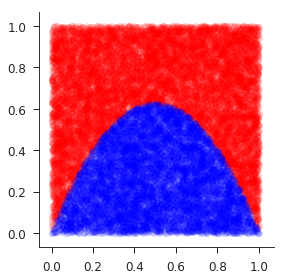

In [33]:
N = 20000
hill_func = lambda dat: (dat[:, 1] >= 2.5*dat[:, 0]*(1-dat[:, 0])).astype(np.float64)
train_space = np.random.rand(N, 2)
train_categ = hill_func(train_space)

red_space = train_space[train_categ==1, :]
blue_space = train_space[train_categ==0, :]
fig, ax = plt.subplots()
ax.scatter(red_space[:, 0], red_space[:, 1], alpha=0.1, color='red');
ax.scatter(blue_space[:, 0], blue_space[:, 1], alpha=0.1, color='blue');
plt.axis('square');

In [51]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(2, activation=tf.nn.softmax),
  tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_space, train_categ, epochs=10);

Epoch 1/10
10000/10000 [==============================] - 1s 131us/step - loss: 0.6833 - acc: 0.5623
Epoch 2/10
10000/10000 [==============================] - 1s 123us/step - loss: 0.6657 - acc: 0.5867
Epoch 3/10
10000/10000 [==============================] - 1s 124us/step - loss: 0.6381 - acc: 0.5886
Epoch 4/10
10000/10000 [==============================] - 1s 122us/step - loss: 0.5897 - acc: 0.6649
Epoch 5/10
10000/10000 [==============================] - 1s 125us/step - loss: 0.5298 - acc: 0.7646
Epoch 6/10
10000/10000 [==============================] - 1s 123us/step - loss: 0.4742 - acc: 0.8082
Epoch 7/10
10000/10000 [==============================] - 1s 126us/step - loss: 0.4316 - acc: 0.8219
Epoch 8/10
10000/10000 [==============================] - 1s 124us/step - loss: 0.4023 - acc: 0.8267
Epoch 9/10
10000/10000 [==============================] - 1s 126us/step - loss: 0.3828 - acc: 0.8295
Epoch 10/10
10000/10000 [==============================] - 1s 120us/step - loss: 0.3701 - a

In [52]:
valid_space = np.random.rand(N, 2)
valid_categ = hill_func(valid_space)

valid_pred = model.predict(valid_space).argmax(axis=1)
np.mean(valid_pred==valid_categ)

0.85

## Overfitting

In [31]:
from sklearn.utils import shuffle

In [32]:
# parameters
N = 1000 # number of series
T = 10 # total time length
L = 4 # sequence length
K = T - L # number of subseries

In [33]:
# generate overlapping sequences
def generate_sequences(vec):
    series = np.stack([vec[:, i:i+L] for i in range(K)], axis=-1).swapaxes(1, 2).reshape((N*K, -1))
    target = vec[:, L:].reshape((N*K,))
    return series, target

In [34]:
# generate training data
train_return = np.random.randn(N, T)
train_series, train_target = generate_sequences(train_return)

# generate validation data
valid_return = np.random.randn(N, T)
valid_series, valid_target = generate_sequences(valid_return)

# sample output
print(np.hstack([train_series, train_target[:, None]])[:10, :])

# shuffle samples
train_series, train_target = shuffle(train_series, train_target)
valid_series, valid_target = shuffle(valid_series, valid_target)

[[ 0.79697507  1.1297955   0.40541669 -2.1371882   0.44538258]
 [ 1.1297955   0.40541669 -2.1371882   0.44538258  1.20914231]
 [ 0.40541669 -2.1371882   0.44538258  1.20914231 -0.00841257]
 [-2.1371882   0.44538258  1.20914231 -0.00841257  1.50735116]
 [ 0.44538258  1.20914231 -0.00841257  1.50735116 -0.03382734]
 [ 1.20914231 -0.00841257  1.50735116 -0.03382734 -0.23850335]
 [ 0.86339088 -0.11748564  1.36847217  1.24662193  0.70591232]
 [-0.11748564  1.36847217  1.24662193  0.70591232  2.41397757]
 [ 1.36847217  1.24662193  0.70591232  2.41397757  0.53672997]
 [ 1.24662193  0.70591232  2.41397757  0.53672997 -1.06369024]]


In [44]:
# number of hidden units
hid = 5

# construct model symbolically as a graph (of placeholders, variables, and operations)
trader_graph = tf.Graph()
with trader_graph.as_default():
    # these are where we'll "feed" batches of data in
    x = tf.placeholder(dtype=tf.float64, shape=(None, L), name='x')
    y = tf.placeholder(dtype=tf.float64, shape=(None,), name='y')

    # these are symbols representing our network weights
    W0 = tf.Variable(tf.random_normal((L, hid), dtype=tf.float64), name='weight0')
    b0 = tf.Variable(tf.random_normal((1, hid), dtype=tf.float64), name='bias0')

    W1 = tf.Variable(tf.random_normal((hid, 1), dtype=tf.float64), name='weight1')
    b1 = tf.Variable(tf.random_normal((1, 1), dtype=tf.float64), name='bias1')

    # two layer neural network, RELU + logits
    hidden = tf.nn.sigmoid(tf.matmul(x, W0) + b0)
    logits = tf.squeeze(tf.matmul(hidden, W1) + b1)
    recom = tf.sigmoid(logits)
    
    # without cheating (divided by N)
    retn = recom*y
    totr = tf.reduce_mean(retn)

    # this is an operation that optimizes an objective function
    opt = tf.train.AdamOptimizer(learning_rate=0.1)
    minn = opt.minimize(-totr)
    
    # this must go at the end!
    init = tf.global_variables_initializer()

In [45]:
def neural_trader(train_x, train_y, valid_x, valid_y, K=100):
    sess = tf.get_default_session()
    
    # save history of training (the old fashioned way)
    train_hist = []
    valid_hist = []
    params = [totr]
    names = ['return']

    # map real data into placeholders
    train_data = {x: train_x, y: train_y}
    valid_data = {x: valid_x, y: valid_y}

    # initialize variables (our coefficients)
    init.run()

    # run for a fixed period and hope for convergence
    for i in range(K):
        for batch in batch_dict(train_data, batch_size):
            minn.run(feed_dict=batch)
            pass
        train_hist.append(sess.run(params, feed_dict=train_data))
        valid_hist.append(sess.run(params, feed_dict=valid_data))

    # turn history into dataframe
    history = pd.concat([
        pd.DataFrame(train_hist, columns=names).add_prefix('train_'),
        pd.DataFrame(valid_hist, columns=names).add_prefix('valid_')
    ], axis=1)
    
    # return results
    return history

train_return    0.050987
valid_return    0.014649
Name: 199, dtype: float64


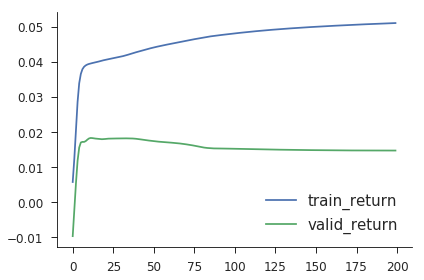

In [46]:
sess = tf.Session(graph=trader_graph)
with sess.as_default():
    history = neural_trader(train_series, train_target, valid_series, valid_target, K=200)
print(history.iloc[-1])
history.plot();

## With Momentum

In [42]:
momentum = 0.2

In [43]:
# generate training data
train_mean = momentum*np.random.randn(N)
train_return = train_mean[:, None] + np.random.randn(N, T)
train_series, train_target = generate_sequences(train_return)

# generate validation data
valid_mean = momentum*np.random.randn(N)
valid_return = valid_mean[:, None] + np.random.randn(N, T)
valid_series, valid_target = generate_sequences(valid_return)

# sample output
print(np.hstack([train_series, train_target[:, None]])[:10, :])

# shuffle samples
train_series, train_target = shuffle(train_series, train_target)
valid_series, valid_target = shuffle(valid_series, valid_target)

[[ 0.08783229 -1.35321166 -0.80589852 -0.34856085 -1.80661256]
 [-1.35321166 -0.80589852 -0.34856085 -1.80661256  0.09836163]
 [-0.80589852 -0.34856085 -1.80661256  0.09836163  0.46706609]
 [-0.34856085 -1.80661256  0.09836163  0.46706609 -0.40553724]
 [-1.80661256  0.09836163  0.46706609 -0.40553724 -0.83293868]
 [ 0.09836163  0.46706609 -0.40553724 -0.83293868 -0.78149727]
 [-2.89928769 -0.22258303  0.7672155  -0.43948753  0.79923915]
 [-0.22258303  0.7672155  -0.43948753  0.79923915  0.13191053]
 [ 0.7672155  -0.43948753  0.79923915  0.13191053  0.24925656]
 [-0.43948753  0.79923915  0.13191053  0.24925656 -0.9943981 ]]


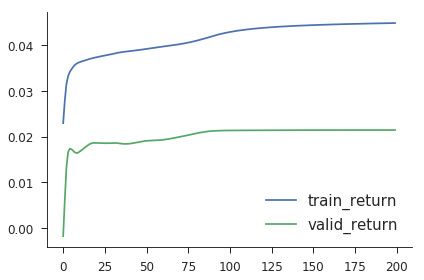

In [62]:
sess = tf.Session(graph=trader_graph)
with sess.as_default():
    history = neural_trader(train_series, train_target, valid_series, valid_target, K=200)
history.plot();

## Dropout

In [47]:
hid = 5 # number of hidden units
keep0 = 0.5 # default keep probability

In [48]:
# construct model symbolically as a graph (of placeholders, variables, and operations)
dropout_graph = tf.Graph()
with dropout_graph.as_default():
    # these are where we'll "feed" batches of data in
    x = tf.placeholder(dtype=tf.float64, shape=(None, L), name='x')
    y = tf.placeholder(dtype=tf.float64, shape=(None,), name='y')
    keep_prob = tf.placeholder_with_default(np.float64(keep0), shape=(), name='keep_prob')

    # these are symbols representing our network weights
    W0 = tf.Variable(tf.random_normal((L, hid), dtype=tf.float64), name='weight0')
    b0 = tf.Variable(tf.random_normal((1, hid), dtype=tf.float64), name='bias0')

    W1 = tf.Variable(tf.random_normal((hid, 1), dtype=tf.float64), name='weight1')
    b1 = tf.Variable(tf.random_normal((1, 1), dtype=tf.float64), name='bias1')

    # two layer neural network, RELU + logits
    hidden = tf.nn.sigmoid(tf.matmul(x, W0) + b0)
    dropout = tf.nn.dropout(hidden, keep_prob)
    logits = tf.squeeze(tf.matmul(dropout, W1) + b1)
    recom = tf.sigmoid(logits)
    
    # without cheating (divided by N)
    retn = recom*y
    totr = tf.reduce_mean(retn)

    # this is an operation that optimizes an objective function
    opt = tf.train.AdamOptimizer(learning_rate=0.1)
    minn = opt.minimize(-totr)
    
    # this must go at the end!
    init = tf.global_variables_initializer()

In [49]:
def dropout_trader(train_x, train_y, valid_x, valid_y, K=100):
    sess = tf.get_default_session()
    
    # save history of training (the old fashioned way)
    train_hist = []
    valid_hist = []
    params = [totr]
    names = ['return']

    # map real data into placeholders
    train_data = {x: train_x, y: train_y}
    valid_data = {x: valid_x, y: valid_y}
    
    # evaluation feeds
    train_eval = {x: train_x, y: train_y, keep_prob: 1.0}
    valid_eval = {x: valid_x, y: valid_y, keep_prob: 1.0}

    # initialize variables (our coefficients)
    init.run()

    # run for a fixed period and hope for convergence
    for i in range(K):
        for batch in batch_dict(train_data, batch_size):
            minn.run(feed_dict=batch)
            pass
        train_hist.append(sess.run(params, feed_dict=train_eval))
        valid_hist.append(sess.run(params, feed_dict=valid_eval))

    # turn history into dataframe
    history = pd.concat([
        pd.DataFrame(train_hist, columns=names).add_prefix('train_'),
        pd.DataFrame(valid_hist, columns=names).add_prefix('valid_')
    ], axis=1)
    
    # return results
    return history

train_return    0.041971
valid_return    0.013098
Name: 199, dtype: float64


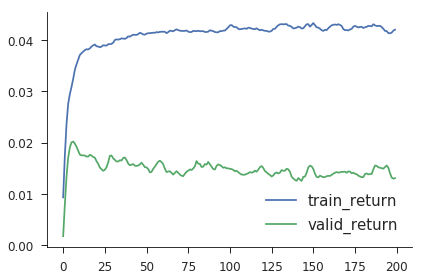

In [50]:
sess = tf.Session(graph=dropout_graph)
with sess.as_default():
    history = dropout_trader(train_series, train_target, valid_series, valid_target, K=200)
print(history.iloc[-1])
history.plot();

## Text Analysis

In [7]:
import os
import re
import json
import time
import html

In [8]:
import sklearn.feature_extraction.text as fe
from sklearn.model_selection import train_test_split
import tflearn
from tflearn.data_utils import to_categorical

In [9]:
def clean_tweet(text):
    text = text.lower().strip()

    # odd subs
    text = re.sub(r'’', '\'', text)
    text = re.sub(r'—', '-', text)

    # urls
    text = re.sub(r'\bhttps?://[\S]*\b', r' ', text)
    text = html.unescape(text)

    # acronyms
    text = re.sub(r'\.{2,}', r'.', text)
    text = re.sub(r'(\S)\.(\S)\.', r'\1\2', text)
    text = re.sub(r'(\S)\.(\S)\.(\S)\.', r'\1\2\3', text)

    # control chars
    text = re.sub(r'([!\.&,])', r' \1 ', text)
    text = re.sub(r'[^ a-z0-9#@!\.&,\']', r' ', text)
    text = re.sub(r'[0-9\']', r'', text)

    # clean up
    text = re.sub(r' {2,}', r' ', text)
    text = text.strip()

    # combine
    return text

In [10]:
# load data for 2016 and 2017
trump_dir = '/media/Liquid/data/tweets/trump_tweet_data_archive'
tweets16 = pd.read_json(os.path.join(trump_dir, 'condensed_2016.json'))
tweets17 = pd.read_json(os.path.join(trump_dir, 'condensed_2017.json'))
tweets = pd.concat([tweets16, tweets17])

# get rid of quote tweets and retweets
rt_mark = tweets['text'].apply(lambda s: s.startswith('"@') or s.startswith('rt'))
tweets = tweets[(~tweets['is_retweet'])&(~rt_mark)&tweets['in_reply_to_user_id_str'].isnull()]
tweets['isource'] = tweets['source'].map({'Twitter for iPhone': 0, 'Twitter for Android': 1})
tweets = tweets.dropna(subset=['isource'])
tweets['isource'] = tweets['isource'].astype(np.int)

# prune down text to basic words
tweets['clean_text'] = tweets['text'].apply(clean_tweet)

In [11]:
# collect input/output data, output is categorical
corpus = list(tweets['clean_text'])
categ = to_categorical(tweets['isource'].values, 2)
print(len(corpus))

3460


In [12]:
# text complexity
all_text = ' '.join(corpus)
all_toks = all_text.split()
all_vocab = list(set(all_toks))
num_toks = len(all_toks)
num_wrds = len(all_vocab)
print(f'total words: {num_toks}')
print(f'distinct words: {num_wrds}')
print(f'ratio = {num_wrds/num_toks}')

total words: 67000
distinct words: 5622
ratio = 0.08391044776119402


In [13]:
# vectorize words weighting them with Tf-Idf scheme
tfidf = fe.TfidfVectorizer()
counts = tfidf.fit_transform(corpus).todense()
n_twt, n_wrd = counts.shape
print(f'n_twt = {n_twt}, n_wrd = {n_wrd}')

n_twt = 3460, n_wrd = 5537


In [14]:
# set aside 10% of data for validation
(train_x, valid_x, train_y, valid_y) = train_test_split(counts, categ, test_size=0.1)

In [15]:
# function to generate a neural network
def generate_nn(n_wrd, nn_size, dropout):
    net = tflearn.input_data([None, n_wrd])
    net = tflearn.fully_connected(net, nn_size, activation='softmax')
    net = tflearn.dropout(net, 1-dropout)
    net = tflearn.fully_connected(net, 2, activation='softmax')
    net = tflearn.regression(net, optimizer='adam', loss='categorical_crossentropy')
    model = tflearn.DNN(net, clip_gradients=0.0, tensorboard_verbose=1,
        tensorboard_dir='/tmp/tflearn_logs/neural', checkpoint_path='checkpoints/neural')
    return model

In [16]:
tf.reset_default_graph()
model = generate_nn(n_wrd, 128, 0.5)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [17]:
run_id = 'neural_%s' % time.strftime('%Y_%m%d_%H%M')
model.fit(train_x, train_y, validation_set=(valid_x, valid_y),
          show_metric=True, n_epoch=25, run_id=run_id)

Training Step: 1224  | total loss: 0.39070 | time: 1.122s
| Adam | epoch: 025 | loss: 0.39070 - acc: 0.8803 -- iter: 3072/3114
Training Step: 1225  | total loss: 0.38862 | time: 2.151s
| Adam | epoch: 025 | loss: 0.38862 - acc: 0.8813 | val_loss: 0.44592 - val_acc: 0.8382 -- iter: 3114/3114
--
INFO:tensorflow:/media/Liquid/work/data_science/checkpoints/neural-1225 is not in all_model_checkpoint_paths. Manually adding it.


In [18]:
all_prob = model.predict(counts)
android_prob = all_prob[:, 1]
androidy = list(tweets['text'].iloc[android_prob.argsort()[::-1]])

In [19]:
print('\n\n'.join(androidy[:5]))

Only reason the hacking of the poorly defended DNC is discussed is that the loss by the Dems was so big that they are totally embarrassed!

Why doesn't the media want to report that on the two "Big Thursdays" when Crooked Hillary and I made our speeches - Republican's won ratings

Ted Cruz didn't win Iowa, he stole it. That is why all of the polls were so wrong and why he got far more votes than anticipated. Bad!

Hillary and the Dems were never going to beat the PASSION of my voters. They saw what was happening in the last two weeks before the......

I said that Crooked Hillary Clinton is "not qualified" to be president because she has "very bad judgement" - Bernie said the same thing!


In [20]:
print('\n\n'.join(androidy[-5:]))

Thank you America! #Trump2016
#MakeAmericaGreatAgain https://t.co/8B0J8Xt3dh

THANK YOU AMERICA! 
#MakeAmericaGreatAgain #Trump2016 https://t.co/TRrdR0nlpM

Thank you, America!
#MakeAmericaGreatAgain #Trump2016 https://t.co/7xxWD0au9H

THANK YOU, AMERICA! #Trump2016
#MakeAmericaGreatAgain 
https://t.co/09hTbBgPHf https://t.co/uJnmDnvkUv

THANK YOU!  
#MakeAmericaGreatAgain #Trump2016
https://t.co/nvgOPoo5qf https://t.co/0JCjfbcpJZ


## Long Short-Term Memory (LSTM)

### WARNING: This section is pretty memory intensive.

In [21]:
from tflearn.data_utils import string_to_semi_redundant_sequences, \
    textfile_to_semi_redundant_sequences, random_sequence_from_textfile

In [22]:
maxlen = 25 # length of memory
redun = 3 # stride in data reading
units = 512 # number of hidden units

Moby Dick full text from Project Gutenberg:
https://www.gutenberg.org/files/2701/2701-0.txt

In [26]:
# read in the book
path = os.path.join('data/moby_dick.txt')

# for storing parameters
chk_path = os.path.join('checkpoints/mobydick')

In [27]:
# load corpus text
X, Y, char_idx = textfile_to_semi_redundant_sequences(path, seq_maxlen=maxlen, redun_step=redun)

Vectorizing text...
Text total length: 1,235,186
Distinct chars   : 86
Total sequences  : 411,721


In [30]:
# define model
tf.reset_default_graph()
g = tflearn.input_data([None, maxlen, len(char_idx)])
g = tflearn.lstm(g, units, return_seq=True)
g = tflearn.dropout(g, 0.5)
g = tflearn.lstm(g, units, return_seq=True)
g = tflearn.dropout(g, 0.5)
g = tflearn.lstm(g, units)
g = tflearn.dropout(g, 0.5)
g = tflearn.fully_connected(g, len(char_idx), activation='softmax')
g = tflearn.regression(g, optimizer='adam', loss='categorical_crossentropy',
                       learning_rate=0.001)
m = tflearn.SequenceGenerator(g, dictionary=char_idx, seq_maxlen=maxlen,
                              clip_gradients=5.0, checkpoint_path=chk_path)

In [31]:
# train model
m.fit(X, Y, validation_set=0.1, batch_size=1024, n_epoch=10, run_id='mobydick')

Training Step: 3619  | total loss: 2.10010 | time: 193.451s
| Adam | epoch: 010 | loss: 2.10010 -- iter: 369664/370548
Training Step: 3620  | total loss: 2.09375 | time: 206.288s
| Adam | epoch: 010 | loss: 2.09375 | val_loss: 2.00553 -- iter: 370548/370548
--
INFO:tensorflow:/media/Liquid/work/data_science/checkpoints/mobydick-3620 is not in all_model_checkpoint_paths. Manually adding it.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


In [7]:
# load a checkpoint
m.load(os.path.join(chk_dir, 'mobydick-3620'))

INFO:tensorflow:Restoring parameters from /media/Liquid/work/notebooks/moby_checkpoints/model_mobydick-3620


In [32]:
seed = random_sequence_from_textfile(path, maxlen)
print(m.generate(600, temperature=0.5, seq_seed=seed))

ead wood has the better of the sace the shoriwing and the fhane of the shound but the clanded as he colmatering an hele the bode to in the captare what ming but of the leen the care the sharp sush the sire to the seed of the wher seen in that man a manter the silling the porpent nest of sorter the see and the chane san in the when seeming the shall the male the shout the cole of the whale and with it in the crood the spopsing of had the shill the seas the whale sheeg that so nean of the such the fare of the sech mor all this was now the sean such coarsed with the should, so mingle of his une that the catter as of the 


In [33]:
seed = random_sequence_from_textfile(path, maxlen)
print(m.generate(600, temperature=1.0, seq_seed=seed))

ed to that languid breezer the
rinkingm ot mad, Semimes spear nown iffoisker the samreavet yor no the high Ill sesselll wowe llenfita, stralbe an Im arount deetn, and to de at the sanmy Ivabe f,aken of thome at yoe
Sor in
the lniund--porncpithtin of yerp'ngeates and leckior. 
Fish a Hatt the have wis eede Bigilacaoonacl and mor Kaying
of AYter of ndeqt. So tis ly the skew out has, in younds on Fhems, thay lecule in to his archas calls the brurper the Pexp?"  strels.

"Peer, and boeg aran lort but absou weed not Inpme ti lode tall len,", sor a how he feipa Ye af Poung
of whiif Ind fip spwo day. fele. The more. Oud! fil


In [34]:
# evaluate probability of a string
k = 128
def find_like(s):
    X0, Y0, _ = string_to_semi_redundant_sequences(s, seq_maxlen=maxlen, redun_step=1, char_idx=char_idx)
    tlen = len(s) - maxlen
    pred = np.vstack([m.evaluate(X0[i:i+k,:,:], Y0[i:i+k,:]) for i in range(0, tlen, k)])
    like = np.mean(np.log([pred[i, char_idx[x]] for i, x in enumerate(s[maxlen:])]))
    return like

In [35]:
find_like('Four score and seven years ago our fathers brought forth on this continent,'
          ' a new nation, conceived in Liberty, and dedicated to the proposition that '
          'all men are created equal.')

Vectorizing text...
Text total length: 176
Distinct chars   : 86
Total sequences  : 151


-1.9319848

In [36]:
find_like(' '.join(100*['whale']))

Vectorizing text...
Text total length: 599
Distinct chars   : 86
Total sequences  : 574


-1.0066937

In [37]:
# words per character
import re
moby_text = open(path).read()
moby_text = moby_text.lower().replace('\n', ' ')
moby_text = re.sub(r'[^a-z ]', r'', moby_text)
moby_text = re.sub(r' +', ' ', moby_text).strip()
moby_toks = moby_text.split()
vocab = list(set(moby_toks))
n_toks = len(moby_toks)
n_wrds = len(vocab)
print(f'total words: {n_toks}')
print(f'distinct words: {n_wrds}')
print(f'ratio = {n_wrds/n_toks}')

total words: 214871
distinct words: 19973
ratio = 0.09295344648649655
